>>> İŞLEM BAŞLATILIYOR...

Veri Yüklendi. İlk Boyut: (638454, 24)
Veri Temizliği ve Encoding Tamamlandı.

>>> FEATURE SELECTION (KORELASYON ANALİZİ) YAPILIYOR...


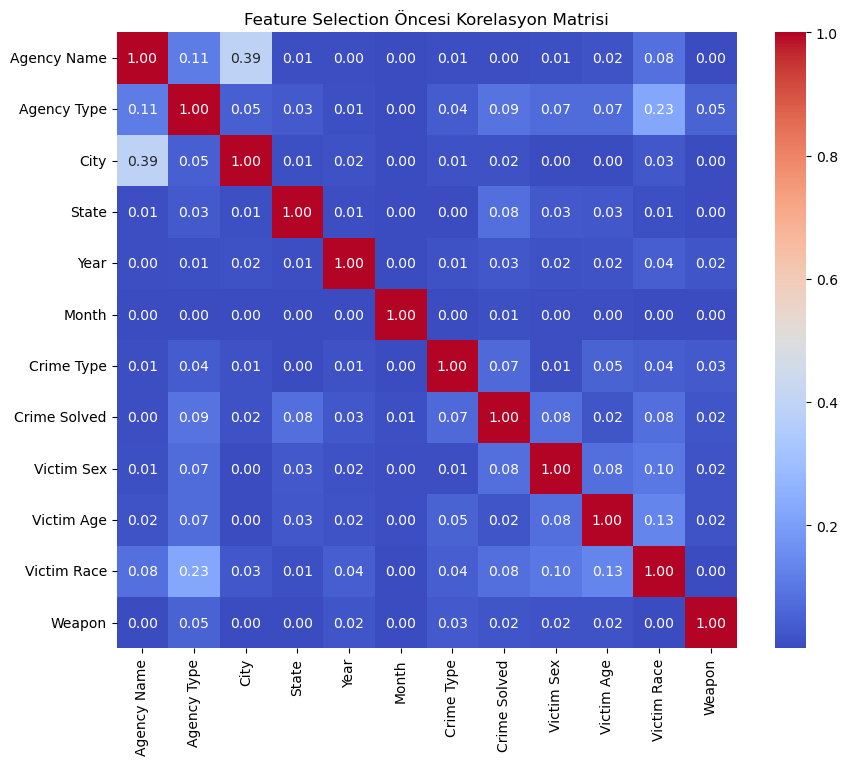

SONUÇ: %90 üzeri benzerlik gösteren sütun bulunamadı. Hiçbir sütun silinmedi.
Model İçin Hazır Veri Boyutu: (638454, 12)

>>> MODEL EĞİTİMİ BAŞLIYOR...
Model Eğitimi Tamamlandı.

       DETAYLI MODEL PERFORMANS RAPORU       
Model: Logistic Regression (Baseline)
Feature Selection: Correlation Analysis (Threshold 0.90)
--------------------------------------------------
1. Accuracy (Doğruluk):      0.5532
2. ROC AUC Score:            0.6096 (Ayırt Edicilik)
3. Cohen's Kappa:            0.1306 (Şanstan Arındırılmış Başarı)
4. Log Loss:                 0.6736 (Hata Payı)
--------------------------------------------------

Classification Report:

              precision    recall  f1-score   support

           0       0.36      0.65      0.46     37875
           1       0.78      0.51      0.62     89816

    accuracy                           0.55    127691
   macro avg       0.57      0.58      0.54    127691
weighted avg       0.65      0.55      0.57    127691



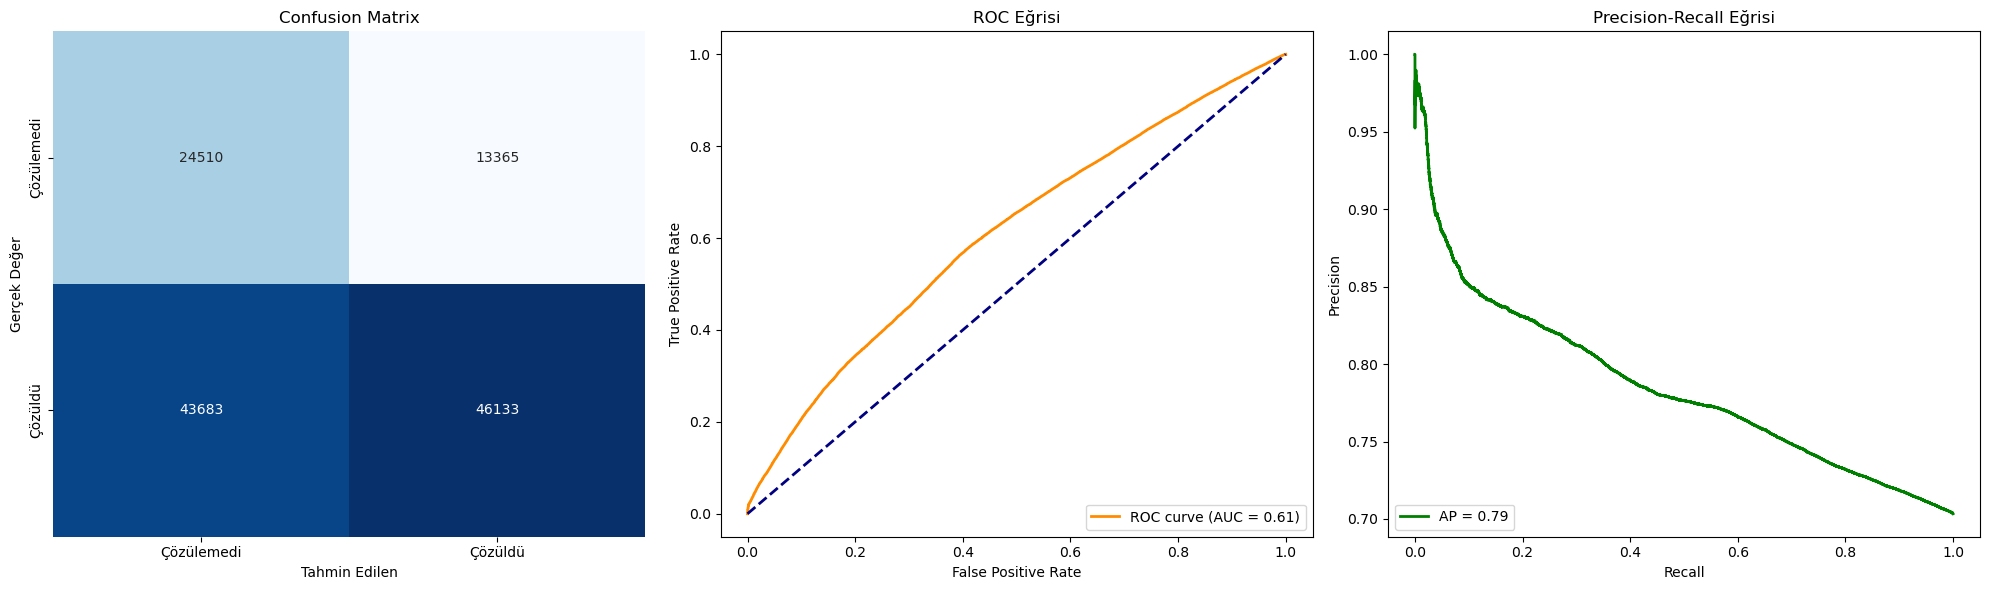

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Gerekli Sklearn Kütüphaneleri
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                             roc_auc_score, roc_curve, precision_recall_curve, 
                             average_precision_score, log_loss, cohen_kappa_score)

# Uyarıları gizle (Temiz çıktı için)
warnings.filterwarnings('ignore')

print(">>> İŞLEM BAŞLATILIYOR...\n")

# ---------------------------------------------------------
# 1. ADIM: VERİ YÜKLEME VE ÖN TEMİZLİK
# ---------------------------------------------------------
df = pd.read_csv('US_Crime_DataSet.csv', low_memory=False)
print(f"Veri Yüklendi. İlk Boyut: {df.shape}")

# Data Leakage (Sızıntı) Önleme ve Gereksiz Sütunları Atma
cols_to_drop = [
    'Record ID', 'Agency Code', 'Incident', 'Record Source',
    'Victim Ethnicity', 'Victim Count',
    'Perpetrator Ethnicity', 'Perpetrator Count',
    'Perpetrator Sex', 'Perpetrator Age', 'Perpetrator Race', 'Relationship'
]
df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])

# Hedef Değişken Dönüşümü (Yes/No -> 1/0)
df['Crime Solved'] = df['Crime Solved'].map({'Yes': 1, 'No': 0})

# Yaş Temizliği (Anormallikleri silip Medyan ile doldurma)
df['Victim Age'] = pd.to_numeric(df['Victim Age'], errors='coerce')
df.loc[(df['Victim Age'] > 99) | (df['Victim Age'] == 0), 'Victim Age'] = np.nan
df['Victim Age'] = df['Victim Age'].fillna(df['Victim Age'].median())

# Kategorik Boşlukları 'Unknown' ile Doldurma
cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    df[col] = df[col].fillna('Unknown')

# Encoding (Sayısallaştırma)
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

print("Veri Temizliği ve Encoding Tamamlandı.")

# ---------------------------------------------------------
# 2. ADIM: FEATURE SELECTION (KORELASYON ANALİZİ)
# ---------------------------------------------------------
print("\n>>> FEATURE SELECTION (KORELASYON ANALİZİ) YAPILIYOR...")

# Korelasyon Matrisi Hesapla
corr_matrix = df.corr().abs()

# Görselleştirme 1: Korelasyon Isı Haritası
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title("Feature Selection Öncesi Korelasyon Matrisi")
plt.show()

# Eşik Değer (Threshold) Belirle: 0.90
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]

if len(to_drop) > 0:
    print(f"Yüksek Korelasyon Nedeniyle Silinen Sütunlar: {to_drop}")
    df.drop(to_drop, axis=1, inplace=True)
else:
    print("SONUÇ: %90 üzeri benzerlik gösteren sütun bulunamadı. Hiçbir sütun silinmedi.")

print(f"Model İçin Hazır Veri Boyutu: {df.shape}")

# ---------------------------------------------------------
# 3. ADIM: MODELLEME (LOGISTIC REGRESSION - BALANCED)
# ---------------------------------------------------------
print("\n>>> MODEL EĞİTİMİ BAŞLIYOR...")

X = df.drop('Crime Solved', axis=1)
y = df['Crime Solved']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling (Ölçeklendirme)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model Kurulumu
log_reg = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
log_reg.fit(X_train_scaled, y_train)

# Tahminler
y_pred = log_reg.predict(X_test_scaled)
y_pred_proba = log_reg.predict_proba(X_test_scaled)[:, 1]

print("Model Eğitimi Tamamlandı.")

# ---------------------------------------------------------
# 4. ADIM: KAPSAMLI RAPORLAMA VE GÖRSELLEŞTİRME
# ---------------------------------------------------------
# Metrikler
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
logloss = log_loss(y_test, y_pred_proba)
kappa = cohen_kappa_score(y_test, y_pred)

print("\n" + "="*50)
print("       DETAYLI MODEL PERFORMANS RAPORU       ")
print("="*50)
print(f"Model: Logistic Regression (Baseline)")
print(f"Feature Selection: Correlation Analysis (Threshold 0.90)")
print("-" * 50)
print(f"1. Accuracy (Doğruluk):      {accuracy:.4f}")
print(f"2. ROC AUC Score:            {roc_auc:.4f} (Ayırt Edicilik)")
print(f"3. Cohen's Kappa:            {kappa:.4f} (Şanstan Arındırılmış Başarı)")
print(f"4. Log Loss:                 {logloss:.4f} (Hata Payı)")
print("-" * 50)
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))
print("="*50)

# --- SON GRAFİKLER (Confusion Matrix, ROC, Precision-Recall) ---
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], cbar=False)
axes[0].set_title('Confusion Matrix')
axes[0].set_xlabel('Tahmin Edilen')
axes[0].set_ylabel('Gerçek Değer')
axes[0].set_xticklabels(['Çözülemedi', 'Çözüldü'])
axes[0].set_yticklabels(['Çözülemedi', 'Çözüldü'])

# 2. ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Eğrisi')
axes[1].legend(loc="lower right")

# 3. Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
avg_precision = average_precision_score(y_test, y_pred_proba)
axes[2].plot(recall, precision, color='green', lw=2, label=f'AP = {avg_precision:.2f}')
axes[2].set_xlabel('Recall')
axes[2].set_ylabel('Precision')
axes[2].set_title('Precision-Recall Eğrisi')
axes[2].legend(loc="lower left")

plt.tight_layout()
plt.show()